<a href="https://colab.research.google.com/github/Enilsonn/my_own/blob/main/Generate_with_zero_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torchvision import datasets

In [24]:
transform = transforms.Compose([
    transforms.Pad(11, padding_mode = 'constant'), #zero paddind
    transforms.ToTensor()
])
train = datasets.MNIST(root = '.', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = 256)

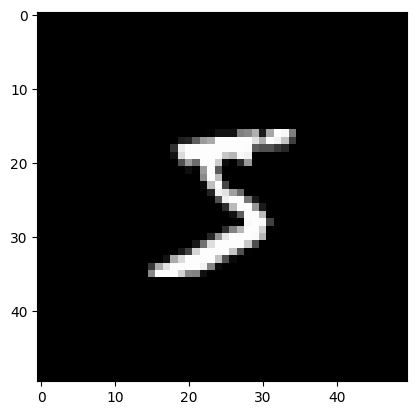

In [25]:
imagem = next(iter(train_loader))[0][0].view(50,50)
plt.imshow(imagem, cmap = 'gray')

In [26]:
class Gerador(nn.Module):
  def __init__(self):
    super().__init__()

    self.dense0 = nn.Linear(700, 400)
    self.dense1 = nn.Linear(400, 1000)
    self.dense2 = nn.Linear(1000, 1600)
    self.dense3 = nn.Linear(1600, 2500)
    self.dropout = nn.Dropout(0.3)

  def forward(self, X):
    X = self.dropout(F.leaky_relu(self.dense0(X),0.2))
    X = self.dropout(F.leaky_relu(self.dense1(X),0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X),0.2))
    X = torch.tanh(self.dense3(X))
    X = X.view(X.shape[0],50,50)
    return X

class Discriminador(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3))
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3))
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (4,4))
    self.bnorm = nn.BatchNorm2d(num_features = 32)
    self.flatten = nn.Flatten()
    self.pool = nn.MaxPool2d(kernel_size = (2,2))

    #conv1 = (50 - 3 + 1) = 48x48
    #pool1 = (48/2) = 24x24

    #conv2 = (24 - 3 + 1) = 22x22
    #pool2 = (20/2) = 11x11

    #conv3 = (11 - 4 + 1) = 8x8
    #pool2 = (8/2) = 4x4

    #faltten = 4x4*32 = 512

    self.dense0 = nn.Linear(512, 128)
    self.dense1 = nn.Linear(128, 32)
    self.dense2 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.2)

  def forward(self, X):
    X = X.view(-1, 1, 50, 50)
    X = self.pool(self.bnorm(F.leaky_relu(self.conv1(X), 0.2)))
    X = self.pool(self.bnorm(F.leaky_relu(self.conv2(X), 0.2)))
    X = self.pool(self.bnorm(F.leaky_relu(self.conv3(X), 0.2)))
    X = self.flatten(X)

    X = self.dropout(F.leaky_relu(self.dense0(X), 0.3))
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.3))
    X = self.dense2(X)
    return X

In [27]:
G = Gerador()
D = Discriminador()

In [28]:
G_optimizer = optim.Adam(G.parameters(), lr = 0.002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.002)

In [29]:
criterion = nn.BCEWithLogitsLoss()
# combina uma camada de sigmiod com uma cama de binarycross entropy loss, ou seja: ja aplica uma funcao de ativacao
# logits = o perceptron n aplicou uma funcao de ativacao

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
G.to(device)

Gerador(
  (dense0): Linear(in_features=700, out_features=400, bias=True)
  (dense1): Linear(in_features=400, out_features=1000, bias=True)
  (dense2): Linear(in_features=1000, out_features=1600, bias=True)
  (dense3): Linear(in_features=1600, out_features=2500, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [32]:
D.to(device)

Discriminador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dense0): Linear(in_features=512, out_features=128, bias=True)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoca 001 finalizada: custo discriminador 0.48113 - custo gerador 7.14971        


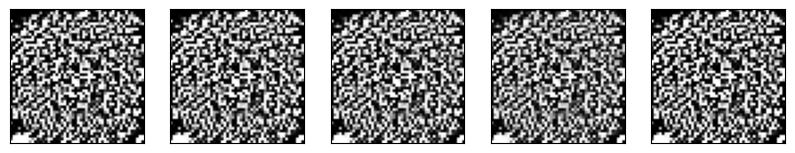

Epoca 002 finalizada: custo discriminador 0.33547 - custo gerador 10.57099        


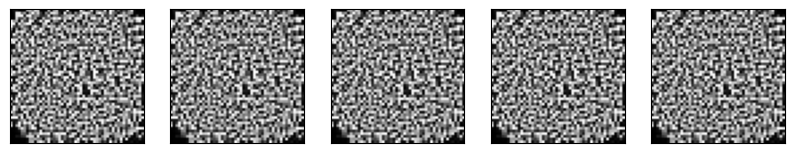

In [ ]:
for epoch in range(100):

  G_running_loss = 0.
  D_running_loss = 0.

  for i, (imagens_reais, _) in enumerate(train_loader):

    # treinamento do gerador
    batch_size = imagens_reais.size(0)
    imagens_reais = (imagens_reais * 2) - 1
    imagens_reais = imagens_reais.to(device)

    G_optimizer.zero_grad()
    ruido = np.random.uniform(low = -1., high = 1., size = (batch_size, 700))
    ruido = torch.from_numpy(ruido).float().to(device)

    imagens_falsas = G.forward(ruido)
    outputs_falsos = D.forward(imagens_falsas)

    labels_falsas = torch.ones(batch_size).to(device)

    G_loss = criterion(outputs_falsos.view(*labels_falsas.shape), labels_falsas)

    G_loss.backward()
    G_optimizer.step()

    #treinamento do discriminador
    ruido = np.random.uniform(low = -1., high = 1., size = (batch_size, 700))
    ruido = torch.from_numpy(ruido).float().to(device)

    D_optimizer.zero_grad()
    outputs_reais = D.forward(imagens_reais)
    labels_reais = (torch.ones(batch_size) * 0.9).to(device)
    D_loss_reais = criterion(outputs_reais.view(*labels_reais.shape), labels_reais)

    imagens_falsas = G.forward(ruido)
    outputs_falsos = D.forward(imagens_falsas)
    labels_falsas = torch.zeros(batch_size).to(device)
    D_loss_falsas = criterion(outputs_falsos.view(*labels_falsas.shape), labels_falsas)

    D_loss = D_loss_reais + D_loss_falsas

    D_loss.backward()
    D_optimizer.step()

    G_running_loss += G_loss.item()
    D_running_loss += D_loss.item()

  D_running_loss /= len(train_loader)
  G_running_loss /= len(train_loader)
  print('Epoca {:03d} finalizada: custo discriminador {:03.5f} - custo gerador {:03.5f}        '.format(epoch + 1, D_running_loss, G_running_loss))

  fig, ax = plt.subplots(1, 5, figsize = (10,5))
  for i in range(5):
    ax[i].imshow(imagens_falsas.cpu().detach().numpy()[i].reshape(50,50), cmap = 'gray')
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
  plt.show()